In [15]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

import emcee
import corner

In [3]:
gw170817 = ascii.read('http://www.tauceti.caltech.edu/kunal/gw170817/gw170817_afterglow_data_full.txt')
data = gw170817.to_pandas()

mask = np.where(data['Telescope'] == 'VLA')[0]
mask1 = np.where(data['Freq'] == 3.000000e+09)[0]
mask2 = np.intersect1d(mask, mask1)

Chandra_mask = np.where(data['Telescope'] == 'Chandra')[0]
Chandra_mask1 = np.where(data['Freq'] == 2.410000e+17)[0]
Chandra_mask2 = np.intersect1d(Chandra_mask, Chandra_mask1)

VLA_flux = np.array(data['FluxD'][mask2])
for index in range(len(VLA_flux)):
    if VLA_flux[index][0] == '<':
        VLA_flux[index] = VLA_flux[index][1:]
    VLA_flux[index] = float(VLA_flux[index])
VLA_time = np.array(data['T'][mask2])

Chandra_data= np.array(data['FluxD'][Chandra_mask2])
for index in range(len(Chandra_data)):
    if Chandra_data[index][0] == '<':
        Chandra_data[index] = Chandra_data[index][1:]
    Chandra_data[index] = float(Chandra_data[index])
Chandra_time = np.array(data['T'][Chandra_mask2])

Chandra_flux = np.array(Chandra_data)*pow(2.410000e+17/3.000000e+09,0.584)

In [25]:
time = np.log(np.append(VLA_time,Chandra_time))
flux = np.append(VLA_flux,Chandra_flux)
t_data = (time)
log_t_data = (t_data)

max_flux_index = np.where(flux == max(flux))[0]
peak_time = time[max_flux_index]
alpha1_est = math.atan(flux[0] - flux[max_flux_index].item())/(time[0] - time[max_flux_index].item())
alpha2_est = math.atan(flux[-1] - flux[max_flux_index].item())/(time[-1] - time[max_flux_index].item())

In [26]:
def model(log_t, nu, beta, Fp, log_tp, s, alpha1, alpha2):
    t = np.exp(log_t)
    tp = np.exp(log_tp)
    return 2**(1/s) * (nu / 3.0)**beta * Fp * ((t / tp)**(-s * alpha1) + (t / tp)**(-s * alpha2))**(-1/s)

# Define the log-likelihood function
def log_likelihood(theta, log_t, nu, F, sigma):
    beta, Fp, log_tp, s, alpha1, alpha2 = theta
    model_F = model(log_t, nu, beta, Fp, log_tp, s, alpha1, alpha2)
    return -0.5 * np.sum(((F - model_F) / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log-prior function
def log_prior(theta):
    beta, Fp, log_tp, s, alpha1, alpha2 = theta
    if 0 < np.exp(log_tp) < 100 and 0 < s < 10 and -10 < beta < 10 and 0 < Fp < 100 and 0 < alpha1 < 10 and 0 < alpha2 < 10:
        return -0.5 * ((beta/2)**2 + (Fp/10)**2 + (log_tp/2)**2 + (s/1)**2 + (alpha1/2)**2 + (alpha2/2)**2)  # Gaussian priors
    else:
        return -np.inf

# Define the log-posterior function
def log_posterior(theta, log_t, nu, F, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + log_likelihood(theta, log_t, nu, F, sigma))

Running burn-in...


  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5116.32it/s]


Running MCMC...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5026.39it/s]


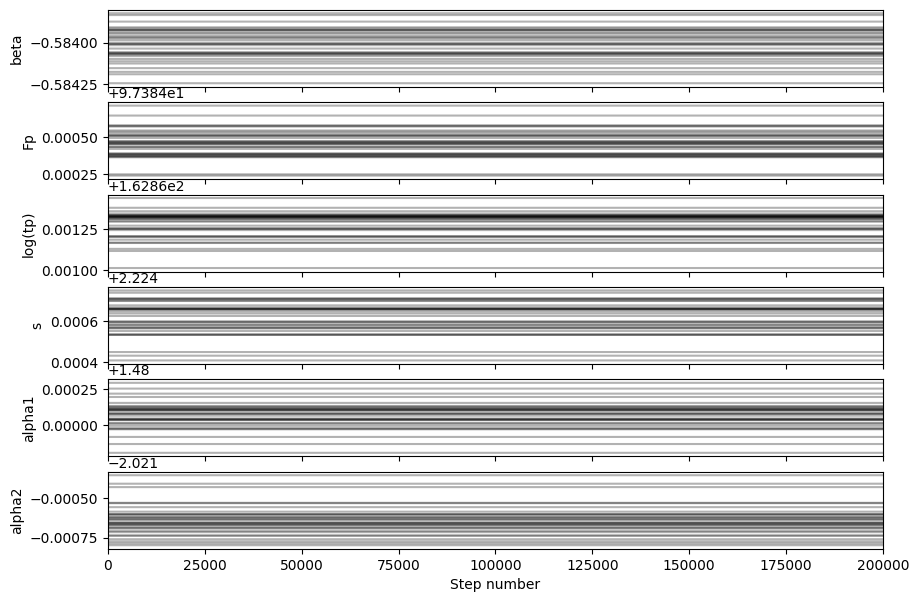

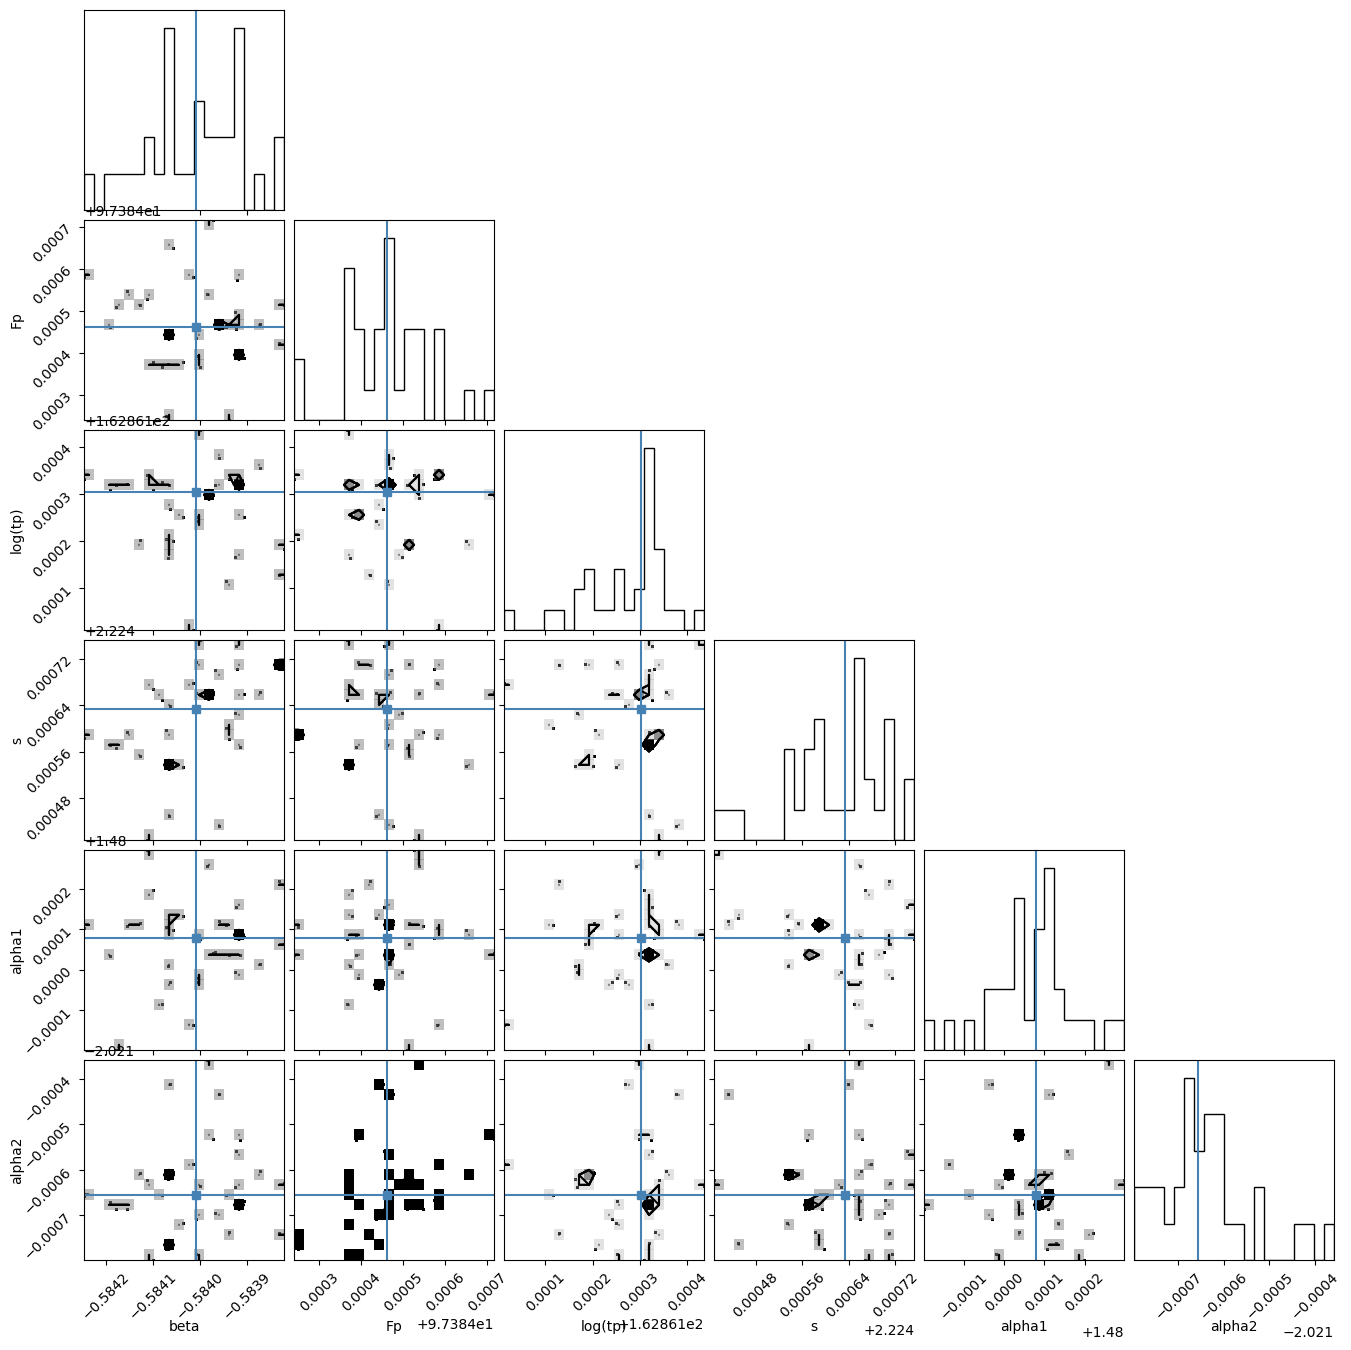

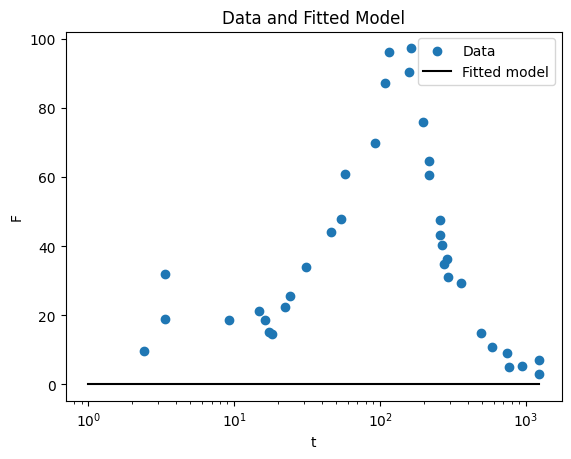

-0.5840081947087523 97.38446110412528 162.86130359463453 2.2246332211953774 1.48007790877335 -2.0216560926081497


In [32]:
t_data = time
nu_data = 3  # Constant observing frequency of 3 GHz
F_data = flux

ndim = 6  # Number of parameters
nwalkers = 32  # Number of walkers
nsteps = 50000  # Number of steps
burnin = 1000  # Burn-in period

# Initial guess for the parameters
#initial = np.array([-0.584, max(flux), peak_time.item(), 1, alpha1_est.item(), alpha2_est.item()])
initial = np.array([-0.584, 97.38445406432662, 162.86128223947676, 2.224600723436645, 1.480073585872019, -2.021640332198968])

pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(log_t_data, nu_data, F_data, 0.1))

# Run the burn-in
print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(pos, burnin, progress=True)
sampler.reset()

# Run the MCMC sampler
print("Running MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True)

# Extract the samples
samples = sampler.get_chain(discard=0, thin=10, flat=True)

# Plot the trace of the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["beta", "Fp", "log(tp)", "s", "alpha1", "alpha2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

beta_mcmc, Fp_mcmc, log_tp_mcmc, s_mcmc, alpha1_mcmc, alpha2_mcmc = np.median(samples, axis=0)
# Plot the posterior distributions
fig = corner.corner(samples, labels=labels, truths=[beta_mcmc, Fp_mcmc, log_tp_mcmc, s_mcmc, alpha1_mcmc, alpha2_mcmc])
plt.show()

# Plot the data and the fitted model
plt.scatter(np.exp(log_t_data), F_data, label='Data')
t_fit = np.linspace(1, max(np.exp(t_data)), 100)
log_t_fit = np.log(t_fit)
F_fit = model(log_t_fit, nu_data, beta_mcmc, Fp_mcmc, log_tp_mcmc, s_mcmc, alpha1_mcmc, alpha2_mcmc)
plt.plot(t_fit, F_fit, color='k', label='Fitted model')
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('F')
plt.legend()
plt.title('Data and Fitted Model')
plt.show()
print(beta_mcmc, Fp_mcmc, log_tp_mcmc, s_mcmc, alpha1_mcmc, alpha2_mcmc)
